# Shifting MNIST dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import jax
import optax
import dojax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from augly import image
from multiprocessing import Pool

from sklearn.decomposition import PCA

In [3]:
cpu_count = os.cpu_count()
print(f"Number of cores: {cpu_count}")

Number of cores: 96


In [4]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [5]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

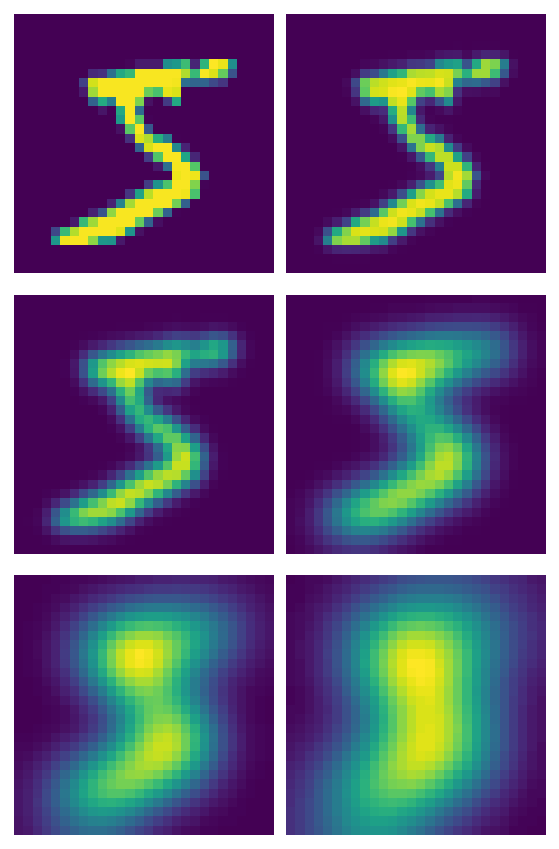

In [6]:
radii = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0]
X_train = np.array(mnist_train.data)
y_train = np.array(mnist_train.targets)

fig, ax = plt.subplots(3, 2, figsize=(4, 6))
for axi, radius in zip(ax.flat, radii):
    x_shift = image.aug_np_wrapper(X_train[0], image.blur, radius=radius)
    axi.imshow(x_shift)
    axi.axis("off")
plt.tight_layout()

In [7]:
class BlurRad:
    def __init__(self, rad):
        self.rad = rad
        
    def __call__(self, img):
        return self.blur_multiple(img)

    def blur(self, X):
        """
        Blur an image using the augly library

        Paramters
        ---------
        X: np.array
            A single NxM-dimensional array
        radius: float
            The amout of blurriness
        """
        return image.aug_np_wrapper(X, image.blur, radius=self.rad)

    def blur_multiple(self, X_batch):
        images_out = []
        for X in X_batch:
            img_blur = self.blur(X)
            images_out.append(img_blur)
        images_out = np.stack(images_out, axis=0)
        return images_out

## Estimating weights

In [8]:
def make_loss_func(model, X, y):
    def loss_fn(params):
        pred = model.apply(params, X)
        loss = optax.softmax_cross_entropy(pred, y).mean()
        return loss
    return loss_fn # Assuming top-level funciton is jitted
    # return jax.jit(loss_fn) # assuming top-level function is not jitted


class MLPWide(nn.Module):
    num_outputs: int
    @nn.compact
    def __call__(self, x):
        # x = x.reshape(-1, 1)
        x = nn.relu(nn.Dense(800)(x))
        x = nn.relu(nn.Dense(500, name="last_layer")(x))
        x = nn.Dense(self.num_outputs)(x)
        x = nn.log_softmax(x)
        return x

    
def print_progress(epoch, loss, step_mod):
    if epoch % step_mod == 0:
        print(f"Loss step ({epoch}: {loss:0.4e})")


@jax.jit
def train_step(params, opt_state, X_batch, y_batch):
    loss_fn = make_loss_func(model, X_batch, y_batch)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params
    

def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch(key, params, opt_step, X, y, batch_size, epoch):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, params = train_step(params, opt_step, X_batch, y_batch)
    
    return params, opt_step


def proc_dataset(radius, img_dataset, n_processes=90):
    """
    Blur all images of a dataset stored in a numpy array.
    
    Parameters
    ----------
    radius: float
        Intensity of bluriness
    img_dataset: array(N, L, K)
        N images of size LxK
    n_processes: int
        Number of processes to blur over
    """
    pool = Pool(processes=n_processes)
    
    dataset_proc = np.array_split(img_dataset, n_processes)
    dataset_proc = pool.map(BlurRad(radius), dataset_proc)
    dataset_proc = np.concatenate(dataset_proc, axis=0)
    
    pool.close()
    
    return dataset_proc

In [13]:
key = jax.random.PRNGKey(314)

alpha = 0.001
n_classes = 10
n_subset = 5000
batch_size = 2_000
n_epochs = 150
alpha = 0.001
tx = optax.adam(learning_rate=alpha)

model = MLPWide(n_classes)
# X_train_ravel = X_train_proc.reshape(-1, 28 ** 2)
# y_train_ohe = jax.nn.one_hot(y_train, n_classes)


def train_model_config(key, radius, num_epochs):
    X_train_proc = proc_dataset(radius, X_train, 90)
    X_train_ravel = X_train_proc.reshape(-1, 28 ** 2)
    y_train_ohe = jax.nn.one_hot(y_train, n_classes)

    batch = jnp.ones((1, 28 ** 2))
    params = model.init(key, batch)
    opt_state = tx.init(params)

    for e in range(num_epochs):
        print(f"@epoch {e+1:03}", end="\r")
        _, key = jax.random.split(key)
        params, opt_state = train_epoch(key, params, opt_state, X_train_ravel, y_train_ohe, batch_size, e)

    final_train_acc = (y_train == model.apply(params, X_train_ravel).argmax(axis=1)).mean().item()
    print(f"@{radius=:0.4f}, {final_train_acc=:0.4f}")
    
    return params, final_train_acc

In [ ]:
hist_params = []
hist_accuracy = []
radii = jnp.linspace(0.001, 3.00, 100)

time_start = time()
for rad in radii:
    params, train_acc = train_model_config(key, rad, n_epochs)
    
    hist_accuracy.append(train_acc)
    hist_params.append(params)

hist_accuracy = jnp.array(hist_accuracy)
time_end = time()
time_total = time_end - time_start
print(f"Total running time: {time_total:0.2f}s")

In [14]:
params, train_acc = train_model_config(key, 1, 1) # used to initialise params
_, reconstruct_pytree_fn = jax.flatten_util.ravel_pytree(params)
reconstruct_pytree_fn

In [17]:
filename_params = "mnist_shift_params.npy"
filename_params = os.path.join("outputs/", filename_params)

if os.path.exists(filename_params):
    hist_params_flat = jnp.load(filename_params)
    # hist_accuracy = jnp.load(filename_accuracy)
else:
    hist_params_flat, reconstruct_pytree_fn = dojax.flat_and_concat_params(hist_params)
    jnp.save(filename, hist_params_flat)
    # jnp.save(filename_accuracy, hist_accuracy)

In [18]:
pca = PCA(n_components=2)
params_proj = pca.fit_transform(hist_params_flat)
params_proj.shape

(100, 2)

NameError: name 'hist_accuracy' is not defined

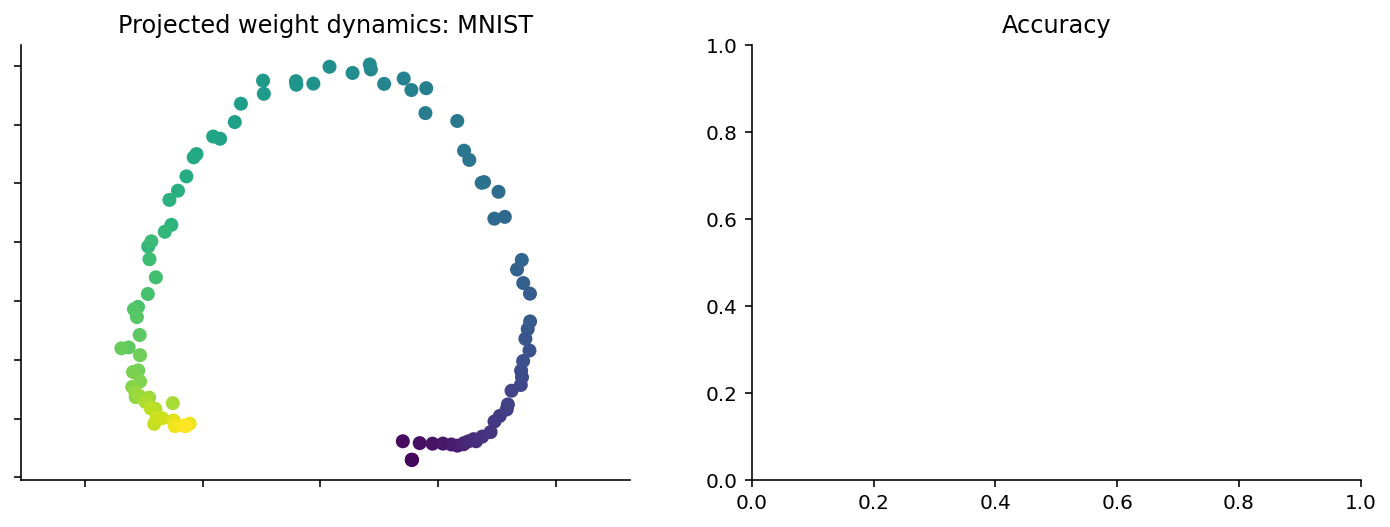

In [19]:
radii = jnp.linspace(0.001, 3.00, 100)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Projected weight dynamics: MNIST")
ax[0].scatter(*params_proj.T, c=radii)
# ax[0].cb(label="radius")
ax[0].tick_params(axis="both", labelleft=False, labelbottom=False)
ax[0].axis("equal")

ax[1].set_title("Accuracy")
ax[1].scatter(radii, hist_accuracy, c=radii)
ax[1].set_xlabel("Radius")
ax[1].set_ylabel("Accuracy")

In [20]:
pca = PCA(n_components=3)
params_proj = pca.fit_transform(hist_params_flat)

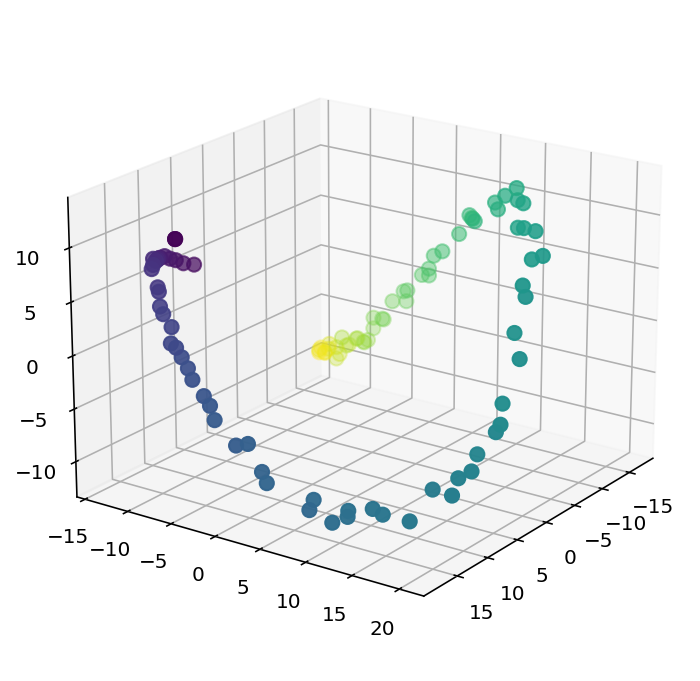

In [21]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection="3d")
ax.view_init(20, 35)
ax.scatter(*params_proj.T, c=radii, s=50);

## Modelling weight dynamics

In [22]:
class MLPWeights(nn.Module):
    num_outputs: int
    @nn.compact
    def __call__(self, x):
        # x = x.reshape(-1, 1)
        x = nn.relu(nn.Dense(200)(x))
        x = nn.Dense(self.num_outputs)(x)
        return x


In [23]:
pca = PCA(n_components=60)
params_proj = pca.fit_transform(hist_params_flat)

### Steps to follow
1. Modify `proc_dataset` so that it takes as input a list of radii and images. Both elements should have the same cardinality over the leading dimension. Its output is a list of images.
2. Modify `make_loss_fn` so that it considers an output in R^d (d-dimensional output with real-valued entries)
3. Modify `get_batch_train_ixs` so that it takes `num_samples` and `num_configs`, where `num_configs` is the total number of configuration. To do this, create a `num_samples x num_configs` count array. Then, given an index `i`, we obtain its config as `i % num_configs`; we obtain its position in the database as `i // num_configs`. Consider the following example:

In [24]:
num_samples = 10
num_configs = 3

samples_ix = jnp.arange(num_samples * num_configs)

In [25]:
# Choose configuration
samples_ix.reshape(num_samples, num_configs) % num_configs

DeviceArray([[0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2]], dtype=int32)

In [26]:
# Choose index
samples_ix.reshape(num_samples, num_configs) // num_configs

DeviceArray([[0, 0, 0],
             [1, 1, 1],
             [2, 2, 2],
             [3, 3, 3],
             [4, 4, 4],
             [5, 5, 5],
             [6, 6, 6],
             [7, 7, 7],
             [8, 8, 8],
             [9, 9, 9]], dtype=int32)

In [27]:
samples_ix[14] // num_configs

DeviceArray(4, dtype=int32)

In [28]:
samples_ix[14] % num_configs

DeviceArray(2, dtype=int32)

4. Modify `train_step` so that it considers the new `make_loss_fn` defined in step `2.`

5. Modify `train_epoch` so that it samples from the indices defined in `3.`. Then, it should return a list of indices to train and radii to try. We modify the input X with the list of radii and obtain our target variable (the weights to predict) given by the list of radii. We then call the modified version of `train_step` (`4.`) with the batch as big as possible (so as to minimise the overhead of computing the transformations of `X`)

### Implementation

https://symbolize.stripped_domain/r/?trace=7f874e96e76d,7f874ea5c3bf&map= 
*** SIGTERM received by PID 572918 (TID 572918) on cpu 19 from PID 570500; stack trace: ***
PC: @     0x7f874e96e76d  (unknown)  syscall
    @     0x7f873e30a7fa        992  (unknown)
    @     0x7f874ea5c3c0  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=7f874e96e76d,7f873e30a7f9,7f874ea5c3bf&map=7a511a57244151c993b16b37978e7ed7:7f872f932000-7f873e674d50 
E0302 11:09:24.741798  572918 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0302 11:09:24.750703  572918 process_state.cc:770] RAW: Raising signal 15 with default behavior


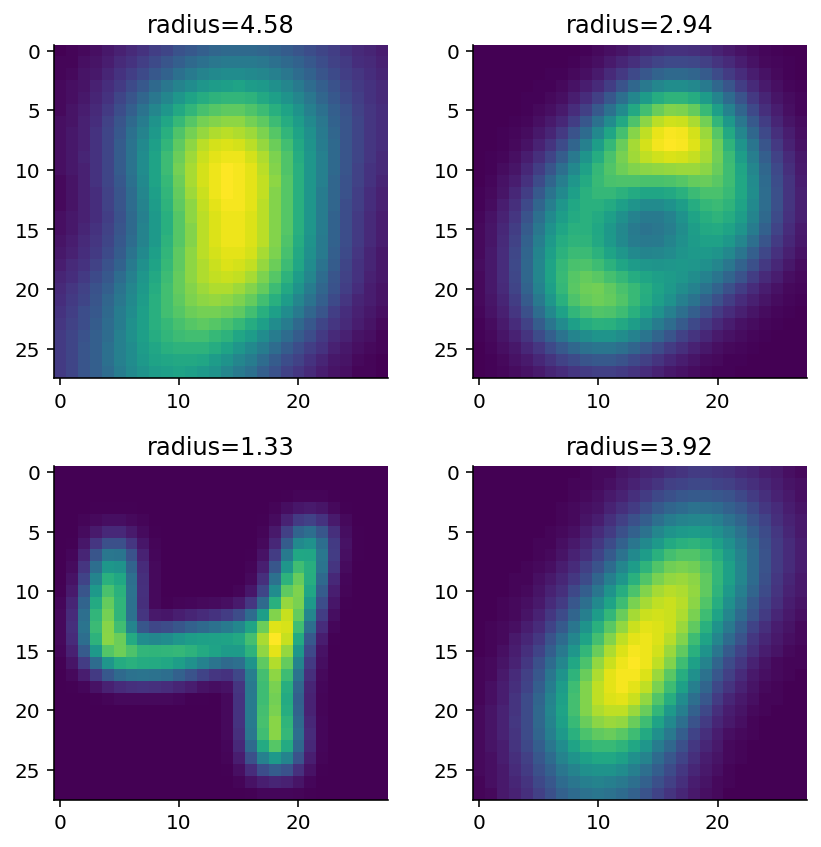

In [29]:
size_subset = 4
n_processes = 4

np.random.seed(314)
radii = np.random.rand(size_subset) * 5

X_train_subset = X_train[:size_subset, ...]
X_train_subset.shape

res = dojax.proc_dataset_multiple(radii, X_train_subset, n_processes)

fig, ax = plt.subplots(2, 2, figsize=(6, 6))
for radius, axi, img in zip(radii, ax.flat, res):
    axi.imshow(img)
    axi.set_title(f"{radius=:0.2f}")
plt.tight_layout()

## Loss function for multiple outputs

$$
    \mathcal{L} = \frac{1}{2N}\sum_{n=1}^N \vert\vert {\bf y}_n - {\bf W}^T\phi({\bf x}_n) \vert\vert^2
$$

In [30]:
def make_loss_func_multiple(model, X, y):
    """
    Loss function for regression problem with multiple outputs
    """
    def loss_fn(params):
        y_hat = model.apply(params, X)
        loss = jnp.linalg.norm(y - y_hat, axis=-1) ** 2
        return loss.mean()
    return loss_fn

In [31]:
weight_model = MLPWeights(10)

In [32]:
batch = jnp.ones((1, 28 ** 2))
params = weight_model.init(key, batch)
opt_state = tx.init(params)

In [33]:
res = dojax.proc_dataset_multiple(radii, X_train_subset, n_processes)
y_test = jax.random.normal(key, (4, 10)) * 10
y_hat = weight_model.apply(params, res.reshape(4, -1))

https://symbolize.stripped_domain/r/?trace=7f872d75784a,7f874ea5c3bf&map= 
*** SIGTERM received by PID 573026 (TID 573026) on cpu 9 from PID 570500; stack trace: ***
PC: @     0x7f872d75784a  (unknown)  __kmp_x86_cpuid
    @     0x7f873e30a7fa        992  (unknown)
    @     0x7f874ea5c3c0  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=7f872d75784a,7f873e30a7f9,7f874ea5c3bf&map=7a511a57244151c993b16b37978e7ed7:7f872f932000-7f873e674d50 
E0302 11:09:35.816255  573026 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0302 11:09:35.824689  573026 process_state.cc:770] RAW: Raising signal 15 with default behavior


### Getting training indices


In [34]:
def get_batch_train_configs_ixs(num_samples, num_configs, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation
    
    We consider a tranining dataset over number of samples and
    number of configurtios.
    """
    num_elements = num_samples * num_configs
    
    steps_per_epoch = num_elements // batch_size
    
    # Maybe we can only use numpy here to avoid sending /
    # calling elements from the TPU
    # batch_ixs = jax.random.permutation(key, num_elements)
    batch_ixs = np.random.permutation(num_elements)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    batch_ixs_samples = batch_ixs // num_configs
    batch_ixs_configs = batch_ixs % num_configs
    
    return batch_ixs_samples, batch_ixs_configs

### The new training step

In [35]:
n_configs, dim_params = params_proj.shape
weight_model = MLPWeights(dim_params)

In [36]:
alpha = 0.0001
tx = optax.adam(learning_rate=alpha)

@jax.jit
def train_step_weights(params, opt_state, X_batch, y_batch):
    loss_fn = make_loss_func_multiple(weight_model, X_batch, y_batch)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params

### New training episode

In [37]:
np.random.seed(314)
batch_size = 100
sample_ixs, config_ixs = get_batch_train_configs_ixs(size_subset, n_configs, batch_size)

In [38]:
sample_batch_ix = sample_ixs[0]
config_batch_ix = config_ixs[0]

In [39]:
radii = np.linspace(0.001, 3.00, 100)

X_batch = X_train_subset[sample_batch_ix, ...]
weights_batch = params_proj[config_batch_ix, ...]
config_batch = radii[config_batch_ix]

In [40]:
n_processes = 20

weight_model = MLPWeights(dim_params)
batch = jnp.ones((1, 28 ** 2))
params = weight_model.init(key, batch)
opt_state = tx.init(params)

In [41]:
def train_epoch_weights(key, params, opt_step, X, configs, target_weights, batch_size, epoch,
                        logger, n_processes=90):
    """
    Training epoch for the projected weights. Note that target weights are the
    target variables
    """
    num_samples = len(X)
    num_configs = len(target_weights)
    n_processes_batch = min(n_processes, batch_size)
    
    sample_ixs, config_ixs = get_batch_train_configs_ixs(num_samples, num_configs, batch_size)
    
    number_partitions = len(sample_ixs)
    for part, (sample_batch_ix, config_batch_ix) in enumerate(zip(sample_ixs, config_ixs)):
        print(f"{part+1:03}/{number_partitions}", end="\r")
        X_batch = X[sample_batch_ix, ...]
        config_batch = configs[config_batch_ix]
        X_batch_transformed = dojax.proc_dataset_multiple(config_batch, X_batch, n_processes_batch).reshape(-1, 28 ** 2)
        
        weights_batch = target_weights[config_batch_ix, ...]
        loss, params = train_step_weights(params, opt_step, X_batch_transformed, weights_batch)

    logger.info(f"@{epoch=} | {loss=:0.4f}")
    return loss, params, opt_step

In [42]:
import pandas as pd

n_train_subset = 6_000
subset_ix = pd.Series(y_train).sample(n_train_subset, random_state=314)
subset_ix = subset_ix.index.values
subset_ix

array([46242, 52277, 30471, ..., 18692,  3212,   220])

## All together

In [43]:
from loguru import logger
logger.add("training-weights.log", rotation="5mb")

1

In [168]:
logger.info("Start of messages")

2022-03-01 18:40:38.088 | INFO     | __main__:<module>:1 - Start of messages


In [ ]:
%%time
batch_size = 10_000
losses = []
for epoch in range(100):
    loss, params, opt_state = train_epoch_weights(key, params, opt_state, X_train[subset_ix], radii,
                                            params_proj, batch_size, epoch, logger)
    losses.append(loss.item())

### Storing and retrieving parameters

```
from flax import serialization
with open("weights-dynamics.params", "wb") as f:
    bytes_params = serialization.to_bytes(params)
    f.write(bytes_params)

with open("weights-dynamics.params", "rb") as f:
    params_reload = serialization.from_bytes(params, f.read())
```

In [47]:
predicted_weights = weight_model.apply(params, X_train[0].ravel())
predicted_weights

DeviceArray([ 1.2580140e+01, -6.8292217e+00,  5.5988770e+00,
              5.2412686e+00, -3.4233327e+00, -3.4819825e+00,
              3.0162313e+00, -1.2083691e+00,  6.9903374e-01,
             -1.4069019e-01,  1.9981846e-01,  5.7997191e-01,
              3.3927101e-01, -5.3004396e-01, -2.1227376e+00,
             -1.8234313e-01,  6.1534464e-02,  2.2112386e-01,
             -5.9752184e-01,  2.1245466e-01, -7.2291297e-01,
             -8.4392510e-02, -2.7413172e-01,  5.8599430e-01,
             -4.9972087e-01, -2.5991447e-02,  2.7943024e-01,
              2.7051464e-01,  8.9725369e-01,  4.2745537e-01,
             -1.9664969e-01,  5.9976465e-01, -2.5679138e+00,
              1.6165617e-01, -2.1035157e-02, -1.3633877e-01,
             -1.4357129e+00,  1.0282533e+00,  5.1670261e-03,
             -1.1178436e+00,  1.9859986e-01, -1.7094951e+00,
             -1.9074145e-01, -4.1237313e-02,  5.8405496e-02,
              1.0237057e-02,  1.2696477e+00, -5.2699655e-01,
              3.5547143e

In [48]:
reconstructed_predicted_weights = pca.inverse_transform(predicted_weights)
reconstructed_predicted_weights = reconstruct_pytree_fn(reconstructed_predicted_weights)

## Testing the model
In this first experiment, we consider a *single* test example with a given configuration, i.e., a level of blurriness and predict the weights corresponding to the given configuration. After predicting the weights, we project back to the full-dimensional parameter space and predict the rest of the elements in the test set.

In [49]:
X_test = np.array(mnist_test.data)
y_test = np.array(mnist_test.targets)

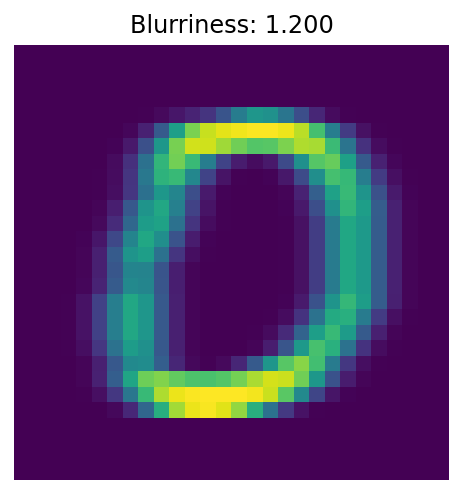

In [88]:
ix = 10
radius = 1.20

shift_config = BlurRad(radius)
x_test_shift = shift_config(X_test[ix])
predicted_weights = weight_model.apply(params, x_test_shift.ravel())
reconstructed_predicted_weights = pca.inverse_transform(predicted_weights)
reconstructed_predicted_weights = reconstruct_pytree_fn(reconstructed_predicted_weights)

plt.imshow(x_test_shift)
plt.title(f"Blurriness: {radius:0.3f}")
plt.axis("off");

In [89]:
model.apply(reconstructed_predicted_weights, x_test_shift.ravel()).argmax()

DeviceArray(0, dtype=int32)

### Predicting the rest of the corrupted digits

In [90]:
from sklearn.metrics import confusion_matrix

In [91]:
%%time
X_test_shift = dojax.proc_dataset_multiple(radius, X_test, n_processes=90)

CPU times: user 96.8 ms, sys: 5.22 s, total: 5.32 s
Wall time: 5.03 s


In [92]:
y_test_hat = model.apply(reconstructed_predicted_weights, X_test_shift.reshape(-1, 28 ** 2))
y_test_hat = y_test_hat.argmax(axis=1)

In [85]:
(y_test_hat == y_test).mean()

DeviceArray(0.9752, dtype=float32)

In [93]:
(y_test_hat == y_test).mean()

DeviceArray(0.9501, dtype=float32)